## Met Office DataPoint Meteogram Maker

The Met Office provide *DataPoint* (https://www.metoffice.gov.uk/services/data/datapoint), a service to access some Met Office data through an API. It's a bit rough round the edges, and has limited documentation. It's free though. Sign up for free, and get your API Key. 

In [1]:
import urllib.request
import requests
import numpy as np
import time
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def f(s):
    #function to convert direction letters into degrees. Stolen from
    #https://codegolf.stackexchange.com/questions/54755/convert-a-point-of-the-compass-to-degrees
    if 'W'in s:
        s = s.replace('N','n')
    a=(len(s)-2)/8
    if 'b' in s:
        a = 1/8 if len(s)==3 else 1/4
        return (1-a)*f(s[:-2])+a*f(s[-1])
    else:
        if len(s)==1:
            return 'NESWn'.find(s)*90
        else:
            return (f(s[0])+f(s[1:]))/2
        

### Get Location ID

call API to get data for desired location code. You can find all codes by calling the API, details on https://www.metoffice.gov.uk/services/data/datapoint/uk-locations-site-list-detailed-documentation

In [3]:
key2='API KEY' #this is your DataPoint API key, as a string.


In [4]:
#get location IDs
link = 'http://datapoint.metoffice.gov.uk/public/data/val/wxfcs/all/json/sitelist?key='+key2
webpage=urllib.request.urlopen(link).read()
cities = json.loads(webpage)

cities_df = pd.DataFrame.from_dict(cities['Locations']['Location'])

In [5]:
cities_df

,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
0,50.0,14,54.9375,-2.8092,Carlisle Airport,nw,Cumbria,NaN,NaN
1,22.0,26,53.3336,-2.85,Liverpool John Lennon Airport,nw,Merseyside,NaN,NaN
2,25.0,33,60.4322,-1.2992,Scatsta,os,Shetland Islands,NaN,NaN
3,7.0,3066,57.6494,-3.5606,Kinloss,gr,Moray,NaN,NaN
4,6.0,3068,57.712,-3.322,Lossiemouth,gr,Moray,LNDSYN,NaN
...,...,...,...,...,...,...,...,...,...
5996,167.0,355886,50.38299,-4.88352,St Dennis,sw,Cornwall,NaN,NaN
5997,108.0,355874,52.415775,-4.059387,Penglais School,wl,Ceredigion,NaN,NaN
5998,0.0,356177,50.6115,-3.4064,Exmouth (Beach),sw,NaN,NaN,NaN
5999,75.0,3930,51.55138,-2.55933,Almondsbury,sw,South Gloucestershire,NaN,NaN


In [6]:
cities_df.loc[cities_df['name'] == 'Cairn Gorm Summit']


,elevation,id,latitude,longitude,name,region,unitaryAuthArea,obsSource,nationalPark
2002,1245.0,3065,57.116,-3.642,Cairn Gorm Summit,he,Moray,NaN,Cairngorms National Park


### Get Data

We're going to get 3 hourly forecast data.

In [7]:
city=3065  #this is the location id code for Cairn Gorm summit. You can find others by calling the API as above.
       
#get data and put in datagframe
df = pd.DataFrame()
today = time.strftime('%Y-%m-%d',time.localtime())
link = 'http://datapoint.metoffice.gov.uk/public/data/val/wxfcs/all/json/'+str(city)+'?res=3hourly&key='+key2
webpage=urllib.request.urlopen(link).read()
data = json.loads(webpage)
i=0
while i<len(data['SiteRep']['DV']['Location']['Period']):
    d2 = data['SiteRep']['DV']['Location']['Period'][i]
    df_t = pd.DataFrame.from_dict(d2['Rep'])
    date = d2['value']
    df_t['Date'] = date
    df = pd.concat([df,df_t])
    i=i+1
        
df=df.reset_index()

In [8]:
#format data as a float rather than a string.
floats = ['F','G','H','Pp','S','T','W','U']
for col in floats:
    df[col]=df[col].astype('float')

In [9]:
#parse date time and direction
df['Hour']=(df['$'].astype(int)/60).astype(int).astype(str)
df['Date/Time'] = pd.to_datetime(df['Date'] + df['Hour'], format='%Y-%m-%dZ%H')
df['Dn'] = df['D'].apply(f)


In [10]:
df = df.rename(columns = {
    'Dn':'Wind Direction',
    'F':'Feels Like Temperature',
    'G':'Wind Gust',
    'H':'Screen Relative Humidity',
    'Pp':'Precipitation probability',
    'S':'Wind Speed',
    'T':'Temperature',
    'V':'Visibility',
    'W':'Weather Type',
    'U':'Max UV Index',
    '$':'Minutes since 0 UTC',
    'Date':'Date'

})

<IPython.core.display.Javascript object>


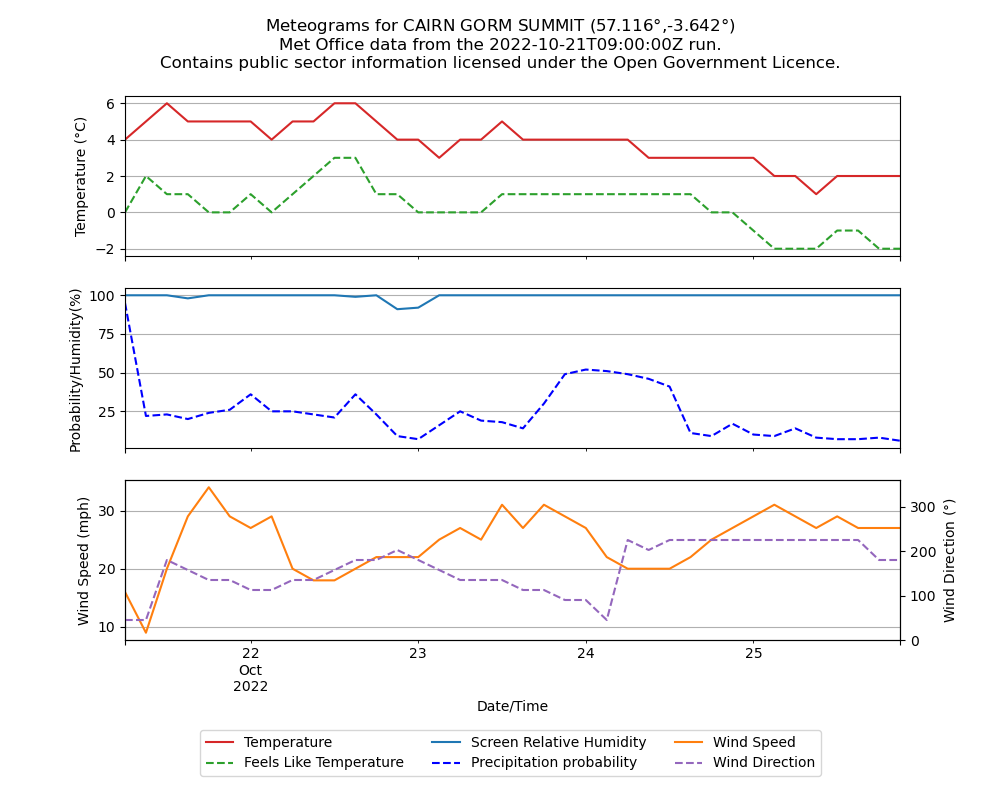

In [12]:
%matplotlib notebook
fig,ax = plt.subplots(3,1,figsize=(10,8),sharex=True)
df.plot('Date/Time','Temperature',ax=ax[0],legend=False,c='tab:red')
df.plot('Date/Time','Feels Like Temperature',ax=ax[0],legend=False,c='tab:green',ls='--')
df.plot('Date/Time','Screen Relative Humidity',ax=ax[1],legend=False,c='tab:blue')
df.plot('Date/Time','Precipitation probability',ax=ax[1],legend=False,c='b',ls='--')
df.plot('Date/Time','Wind Speed',ax=ax[2],legend=False,c='tab:orange')

ax[0].set_ylabel('Temperature (°C)')
ax[1].set_ylabel('Probability/Humidity(%)')
ax[2].set_ylabel('Wind Speed (mph)')
ax3 = ax[2].twinx()
ax3.set_ylim((0,360))


df.plot('Date/Time','Wind Direction',ax=ax3,legend=False,c='tab:purple',ls='--')
ax3.set_ylabel('Wind Direction ($\degree$)')

city = data['SiteRep']['DV']['Location']['name']
lat = data['SiteRep']['DV']['Location']['lat']
lon = data['SiteRep']['DV']['Location']['lon']
dataDate = data['SiteRep']['DV']['dataDate']

fig.suptitle('Meteograms for '+city+ ' ('+lat+'$\degree$,'+lon+'$\degree$)\nMet Office data from the '+dataDate+ ' run.\nContains public sector information licensed under the Open Government Licence.')
fig.legend(ncol=3,loc=(0.2,0.03))
fig.subplots_adjust(bottom=0.2)

for k in range(3):
    ax[k].grid('both')
    
plt.savefig('example_meteogram.jpg',bbox_inches='tight')